In [ ]:
# Import required libraries
import os
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoImageProcessor, AutoModel, TrainingArguments, Trainer
from transformers import ViTForImageClassification, ViTImageProcessor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path FFHQ folder
ffhq_path = '/content/drive/My Drive/FFHQ'

# Get all subfolders
all_folders = [f for f in os.listdir(ffhq_path) if os.path.isdir(os.path.join(ffhq_path, f))]

# Select 3 random folders
real_folders = ['00000', '01000']


print("Real folders:", real_folders)

# Path StyleGAN folder
stylegan_path = '/content/drive/My Drive/StyleGAN'

# Get all zip files
all_zips = [f for f in os.listdir(stylegan_path) if f.lower().endswith('.zip')]

# Select 3 random zip files
fake_zips = ['000000.zip', '001000.zip']

print("Fake zip files:", fake_zips)

Real folders: ['00000', '01000']
Fake zip files: ['000000.zip', '001000.zip']


In [ ]:
# Supported image formats
image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff', '.webp')

# Function to get all image files from a directory
def get_image_files(directory_path):
    try:
        files = os.listdir(directory_path)
        image_files = [
            os.path.join(directory_path, f)
            for f in files
            if f.lower().endswith(image_extensions)
        ]
        return image_files
    except FileNotFoundError:
        print(f"Directory not found: {directory_path}")
        return []
    except PermissionError:
        print(f"Permission denied accessing: {directory_path}")
        return []
    except Exception as e:
        print(f"Error accessing {directory_path}: {e}")
        return []

# Function to extract zip and get images
def get_images_from_zip(zip_path, extract_to='/content/temp_extract'):
    try:
        # Create extraction directory
        os.makedirs(extract_to, exist_ok=True)

        # Extract zip
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)

        # Find all images recursively
        image_files = []
        for root, _, files in os.walk(extract_to):
            for file in files:
                if file.lower().endswith(image_extensions):
                    image_files.append(os.path.join(root, file))
        return image_files
    except Exception as e:
        print(f"Error processing zip {zip_path}: {e}")
        return []

# Get all real images
real_images = []
for folder in real_folders:
    folder_path = os.path.join(ffhq_path, folder)
    real_images.extend(get_image_files(folder_path))

# Get all fake images
fake_images = []
for zip_file in fake_zips:
    zip_path = os.path.join(stylegan_path, zip_file)
    fake_images.extend(get_images_from_zip(zip_path))

print(f"\nTotal real images found: {len(real_images)}")
print(f"Total fake images found: {len(fake_images)}")

if len(real_images) == 0:
    print("Warning: No real images found!")
if len(fake_images) == 0:
    print("Warning: No fake images found!")


Total real images found: 2000
Total fake images found: 3000


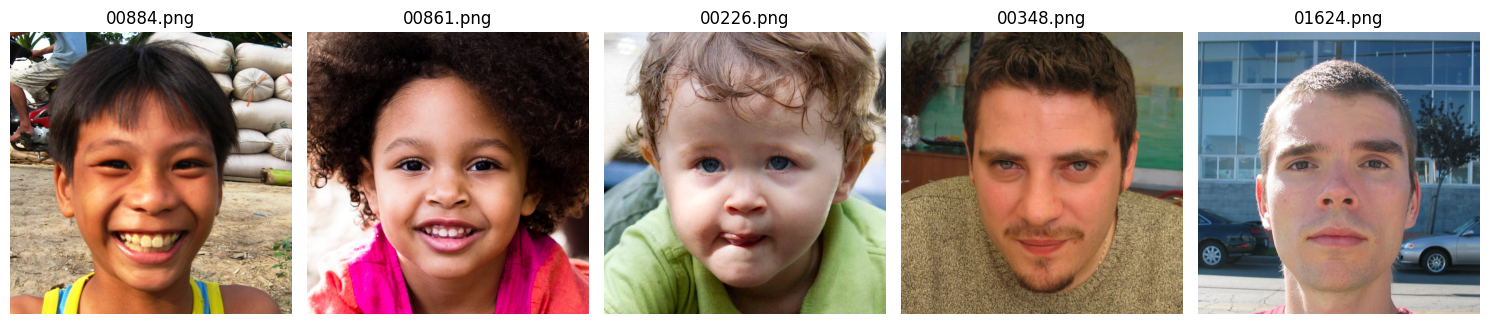

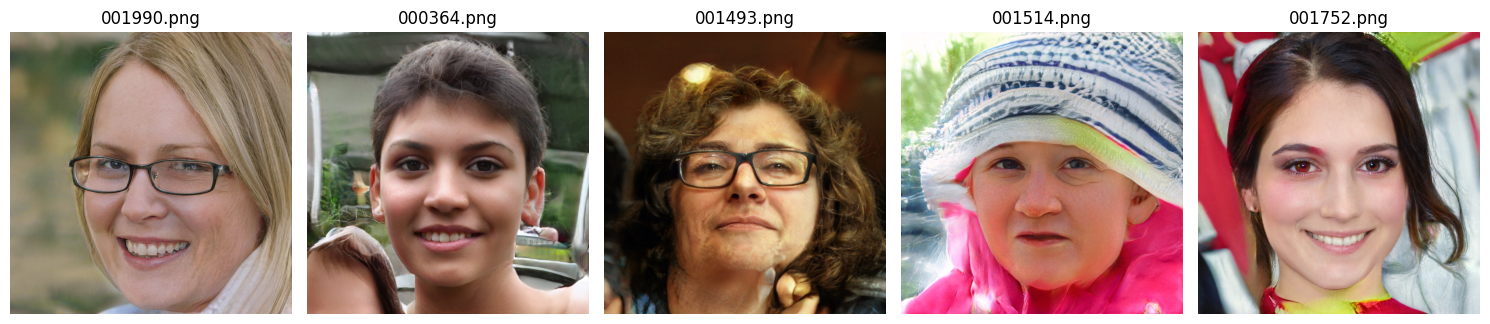

In [ ]:
# Display 5 random real images
sample_real_images = random.sample(real_images, min(5, len(real_images)))
plt.figure(figsize=(15, 5))
for i, image_path in enumerate(sample_real_images):
    image = Image.open(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
plt.tight_layout()
plt.show()

# Display 5 random fake images
sample_fake_images = random.sample(fake_images, min(5, len(fake_images)))
plt.figure(figsize=(15, 5))
for i, image_path in enumerate(sample_fake_images):
    image = Image.open(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
plt.tight_layout()
plt.show()

In [ ]:
# Load pre-trained Vision Transformer model
model_name = "google/vit-base-patch16-224"

# Load the image processor
processor = ViTImageProcessor.from_pretrained(model_name)

# Load the model for binary classification, ignoring size mismatches in the final layer
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification: real vs fake
    id2label={0: "fake", 1: "real"},
    label2id={"fake": 0, "real": 1},
    ignore_mismatched_sizes=True # Ignore size mismatch for the classification head
)

print(f"Model loaded: {model_name}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: google/vit-base-patch16-224
Model parameters: 85,800,194
Trainable parameters: 85,800,194


In [ ]:
num_target_images = 2000
selected_real_images = random.sample(real_images, min(len(real_images), num_target_images))
selected_fake_images = random.sample(fake_images, min(len(fake_images), num_target_images))

all_images = selected_real_images + selected_fake_images
all_labels = [0] * len(selected_real_images) + [1] * len(selected_fake_images)

# Redefine the custom dataset class to NOT apply transformations
class DeepfakeDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
        self.valid_indices = []
        self.corrupted_files = []

        print("Checking image validity...")
        for idx in range(len(self.image_paths)):
            try:
                img_path = self.image_paths[idx]
                with Image.open(img_path) as image:
                    image.verify()
                self.valid_indices.append(idx)
            except Exception as e:
                self.corrupted_files.append((img_path, str(e)))

        print(f"Total images: {len(self.image_paths)}")
        print(f"Valid images: {len(self.valid_indices)}")
        if self.corrupted_files:
            print(f"Corrupted files found: {len(self.corrupted_files)}")
            for file_path, error in self.corrupted_files[:5]:
                print(f"  - {file_path}: {error}")
            if len(self.corrupted_files) > 5:
                print(f"  ... and {len(self.corrupted_files) - 5} more")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        valid_idx = self.valid_indices[idx]
        img_path = self.image_paths[valid_idx]
        label = self.labels[valid_idx]

        try:
            image = Image.open(img_path).convert("RGB")
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

processor = ViTImageProcessor.from_pretrained(model_name)

# Define a custom collate function for the ViT model
def custom_collate_fn_vit(batch):
    # Filter out None values
    batch = [item for item in batch if item is not None and item[0] is not None]
    if len(batch) == 0:
        return {'pixel_values': torch.tensor([]), 'labels': torch.tensor([])}

    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Preprocess images using the ViT processor
    processed_inputs = processor(images=images, return_tensors="pt")
    processed_inputs['labels'] = torch.tensor(labels)

    return processed_inputs

# Create the dataset with balanced images
dataset = DeepfakeDataset(all_images, all_labels)

# Split into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(f"\nDataset split:")
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create data loaders with the new collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn_vit)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn_vit)

print(f"\nData loaders created:")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Checking image validity...
Total images: 4000
Valid images: 4000

Dataset split:
Training set size: 3200
Test set size: 800

Data loaders created:
Training batches: 100
Test batches: 25


In [ ]:
# Define custom collate function for the ViT model
def custom_collate_fn_vit(batch):
    # Filter out None values
    batch = [item for item in batch if item[0] is not None]
    if len(batch) == 0:
        return {'pixel_values': torch.tensor([]), 'labels': torch.tensor([])}

    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Preprocess images using the ViT processor
    processed_inputs = processor(images=images, return_tensors="pt")
    processed_inputs['labels'] = torch.tensor(labels)

    return processed_inputs

# Update data loaders to use the new collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn_vit)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn_vit)


# Define training arguments
training_args = TrainingArguments(
    output_dir="./vit-deepfake-detector",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    eval_strategy="steps",
    eval_steps=100,  # Evaluate every 100 steps
    logging_dir="./logs",
    logging_steps=10,
    num_train_epochs=3,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none"  # Disable Wandb or other reporting
)

# Define a function to compute metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy_score(labels, predictions)}

# Create a custom trainer class
class ViTDeepfakeTrainer(Trainer):
    def get_train_dataloader(self):
        return train_loader

    def get_eval_dataloader(self, eval_dataset=None):
        return test_loader

# Initialize the Trainer
trainer = ViTDeepfakeTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=custom_collate_fn_vit,
)

print("Starting model training...")
# Start training
trainer.train()

Starting model training...


TrainOutput(global_step=300, training_loss=0.13812686292765042, metrics={'train_runtime': 1106.2214, 'train_samples_per_second': 8.678, 'train_steps_per_second': 0.271, 'total_flos': 7.439231003000832e+17, 'train_loss': 0.13812686292765042, 'epoch': 3.0})

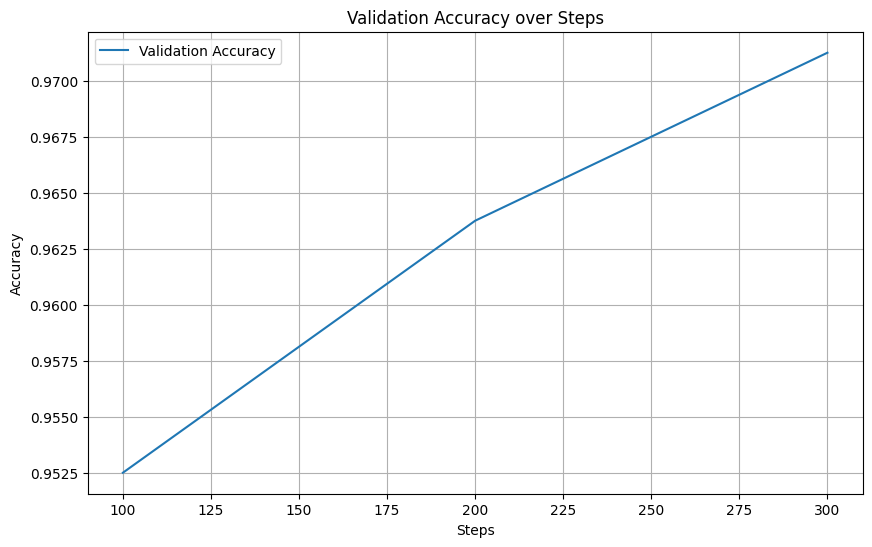

In [ ]:
# Get training history
history = trainer.state.log_history

# Extract metrics
train_acc = []
eval_acc = []
steps = []

for log in history:
    if "eval_accuracy" in log:
        eval_acc.append(log["eval_accuracy"])
        steps.append(log["step"])
    if "loss" in log and "eval_loss" not in log:
        # We can't directly get training accuracy from the default logs
        # Let's plot the loss instead as it's a good proxy for learning
        pass

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(steps, eval_acc, label='Validation Accuracy')
plt.title('Validation Accuracy over Steps')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Testing Accuracy: 0.9712

Classification Report:
              precision    recall  f1-score   support

        real       0.98      0.96      0.97       396
        fake       0.97      0.98      0.97       404

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



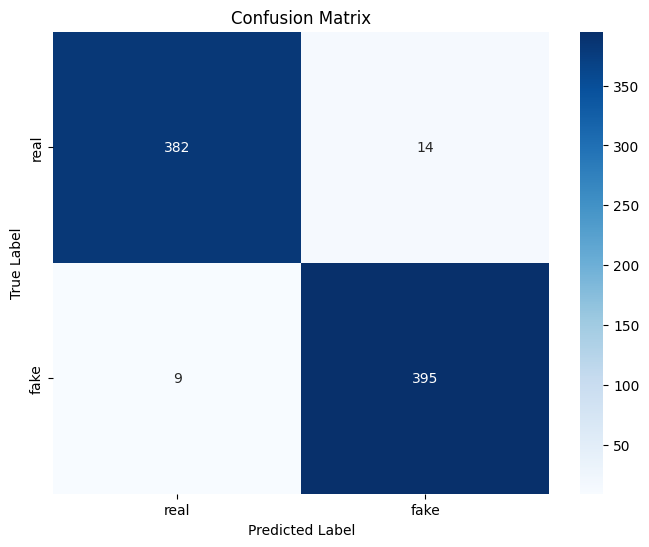

In [ ]:
# Get predictions from the test set
predictions = trainer.predict(test_dataset)

# Extract predicted labels and true labels
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Print the testing accuracy
test_accuracy = predictions.metrics["test_accuracy"]
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Generate the classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=["real", "fake"]))

# Generate and plot the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["real", "fake"], yticklabels=["real", "fake"])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Save the fine-tuned model and processor
model_save_path = "/content/drive/My Drive/deepfake_detection/models/vit-model"
trainer.save_model(model_save_path)
processor.save_pretrained(model_save_path)
print(f"Model and processor saved to {model_save_path}")

Model and processor saved to /content/drive/My Drive/deepfake_detection/models/vit-model


In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor

# Define the path where the model and processor were saved
model_path = "/content/drive/My Drive/deepfake_detection/models/vit-model"

# Load the fine-tuned model
loaded_model = ViTForImageClassification.from_pretrained(model_path)

# Load the corresponding processor
loaded_processor = ViTImageProcessor.from_pretrained(model_path)

# The loaded_model and loaded_processor are now ready for inference or further use.
print("Model and processor loaded successfully!")

Model and processor loaded successfully!


In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 807.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.3 MB/s

In [ ]:
# Import the required Grad-CAM classes
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# Define the target layer for the Vision Transformer model.
# Choice is the output of the last attention block.
target_layer = [loaded_model.vit.encoder.layer[-1].attention.output]

# Define the function for the forward pass, which is required by the Grad-CAM library
def forward_with_label(x):
    outputs = loaded_model(x)
    return outputs.logits

In [ ]:
# Initialize Grad-CAM
# The model is the fine-tuned ViT model
# The target_layers are the outputs of the last attention block
cam = GradCAM(model=loaded_model, target_layers=target_layer)

In [ ]:
def visualize_grad_cam(image_path, model, processor, cam):
    try:
        # Load the image and convert to a numpy array for visualization
        pil_image = Image.open(image_path).convert("RGB")
        numpy_image = np.array(pil_image) / 255.0

        # Preprocess the image for the model
        input_tensor = processor(images=pil_image, return_tensors="pt")['pixel_values']

        # Get the model's output (logits) for the image
        # Do not use torch.no_grad() here, as Grad-CAM needs gradients
        output = model(pixel_values=input_tensor)
        logits = output.logits
        predicted_class_id = logits.argmax().item()

        # The Grad-CAM library expects the model's output to be a tensor.
        # We need to create a ClassifierOutputTarget that points to the predicted class.
        targets = [ClassifierOutputTarget(predicted_class_id)]

        # The Grad-CAM object needs the logits to compute the heatmap
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        # Overlay the heatmap on the original image
        visualization = show_cam_on_image(numpy_image, grayscale_cam, use_rgb=True)

        # Display the results
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(pil_image)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(visualization)
        plt.title(f"Grad-CAM Heatmap\nPredicted Class: {model.config.id2label[predicted_class_id]}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error visualizing Grad-CAM for image {image_path}: {e}")

In [ ]:
num_to_visualize = 3
images_to_visualize = random.sample(fake_images, num_to_visualize)

print(f"\nVisualizing Grad-CAM for {num_to_visualize} random fake images:")
for path in images_to_visualize:
    print(f"  - {path}")
    visualize_grad_cam(path, loaded_model, loaded_processor, cam)


Visualizing Grad-CAM for 3 random fake images:
  - /content/temp_extract/000793.png
Error visualizing Grad-CAM for image /content/temp_extract/000793.png: 'str' object has no attribute 'shape'
  - /content/temp_extract/000997.png
Error visualizing Grad-CAM for image /content/temp_extract/000997.png: 'str' object has no attribute 'shape'
  - /content/temp_extract/001180.png
Error visualizing Grad-CAM for image /content/temp_extract/001180.png: 'str' object has no attribute 'shape'



Visualizing Grad-CAM for 3 random fake images:
  - /content/temp_extract/001266.png


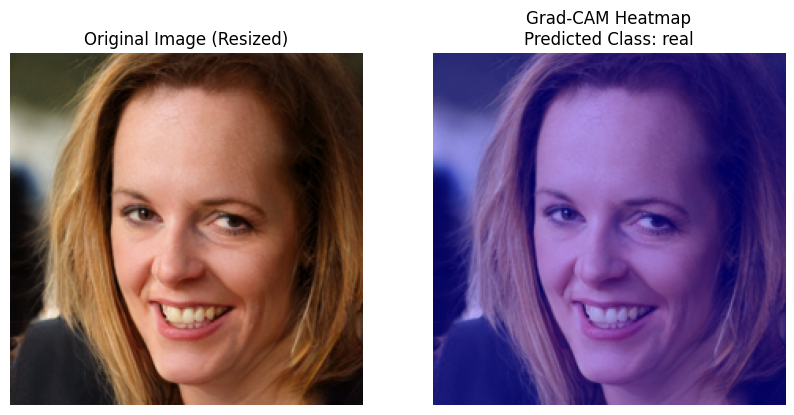

  - /content/temp_extract/000429.png


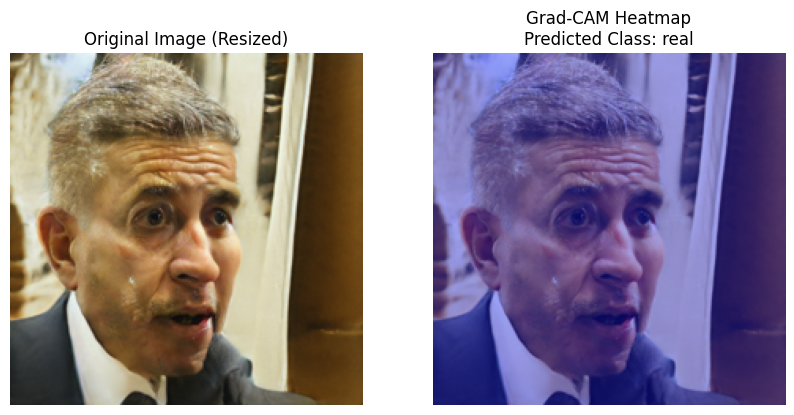

  - /content/temp_extract/001934.png


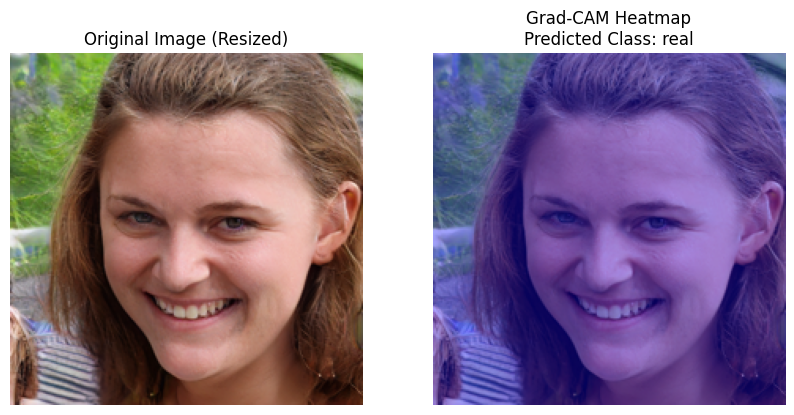

In [ ]:
# --- Part 1: Prerequisites ---
import os
import random
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from transformers import ViTForImageClassification, ViTImageProcessor
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from transformers.modeling_outputs import SequenceClassifierOutput

# (Include your get_image_files and get_images_from_zip functions here)
# (Ensure your paths and file lists are correctly defined)

# --- Part 2: Model and Grad-CAM Setup ---
# Define the path where the model and processor were saved
model_path = "/content/drive/My Drive/deepfake_detection/models/vit-model"

# Load the fine-tuned model and processor
loaded_model = ViTForImageClassification.from_pretrained(model_path)
loaded_processor = ViTImageProcessor.from_pretrained(model_path)

# Create a model wrapper to ensure Grad-CAM receives the raw logits
class ViTModelWrapper(nn.Module):
    def __init__(self, model):
        super(ViTModelWrapper, self).__init__()
        self.model = model
    def forward(self, pixel_values):
        outputs = self.model(pixel_values=pixel_values)
        return outputs.logits

# Wrap the loaded model
wrapped_model = ViTModelWrapper(loaded_model)

# Define the target layer for the Vision Transformer model.
target_layer = [loaded_model.vit.encoder.layer[-1].attention.output]

# Define the reshape transform for ViT
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.permute(0, 3, 1, 2)
    return result

# Initialize Grad-CAM with the wrapped model
cam = GradCAM(model=wrapped_model, target_layers=target_layer, reshape_transform=reshape_transform)


# --- Part 3: Visualization Function ---
def visualize_grad_cam(image_path, model, processor, cam):
    try:
        # Load the image and convert to a numpy array for visualization
        pil_image = Image.open(image_path).convert("RGB")

        # --- FIX: Resize the image to match the model's input size ---
        # The model expects 224x224, and the heatmap will be generated at this size.
        resized_pil_image = pil_image.resize((224, 224))
        numpy_image = np.array(resized_pil_image) / 255.0

        # Preprocess the image for the model
        input_tensor = processor(images=pil_image, return_tensors="pt")['pixel_values']

        # Get the model's prediction and logits
        output = model(pixel_values=input_tensor)
        logits = output.logits
        predicted_class_id = logits.argmax().item()

        # Define the target for Grad-CAM (the predicted class)
        targets = [ClassifierOutputTarget(predicted_class_id)]

        # Generate the Grad-CAM heatmap
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        # Overlay the heatmap on the resized image
        visualization = show_cam_on_image(numpy_image, grayscale_cam, use_rgb=True)

        # Display the results
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(resized_pil_image)
        plt.title("Original Image (Resized)")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(visualization)
        plt.title(f"Grad-CAM Heatmap\nPredicted Class: {model.config.id2label[predicted_class_id]}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error visualizing Grad-CAM for image {image_path}: {e}")

# --- Part 4: Running the Visualization ---
# (Assuming 'fake_images' is populated)
num_to_visualize = 3
if len(fake_images) >= num_to_visualize:
    images_to_visualize = random.sample(fake_images, num_to_visualize)
    print(f"\nVisualizing Grad-CAM for {num_to_visualize} random fake images:")
    for path in images_to_visualize:
        print(f"  - {path}")
        visualize_grad_cam(path, loaded_model, loaded_processor, cam)
else:
    print(f"Not enough fake images to visualize {num_to_visualize}. Found only {len(fake_images)}.")


Visualizing Grad-CAM for 3 random fake images:
  - /content/temp_extract/000278.png


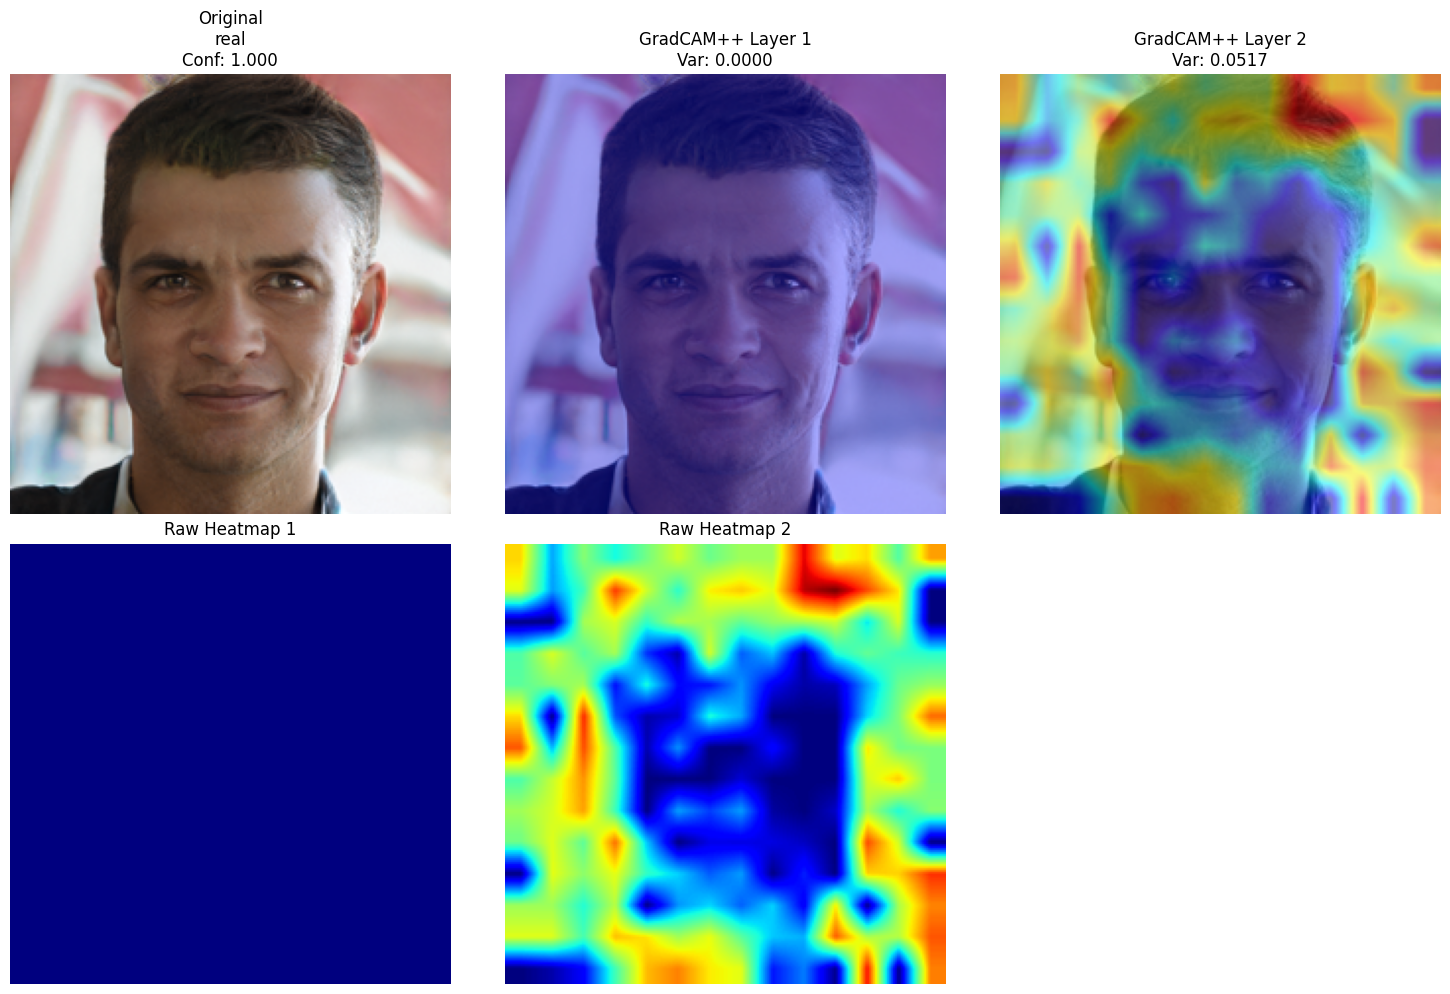

  - /content/temp_extract/001376.png


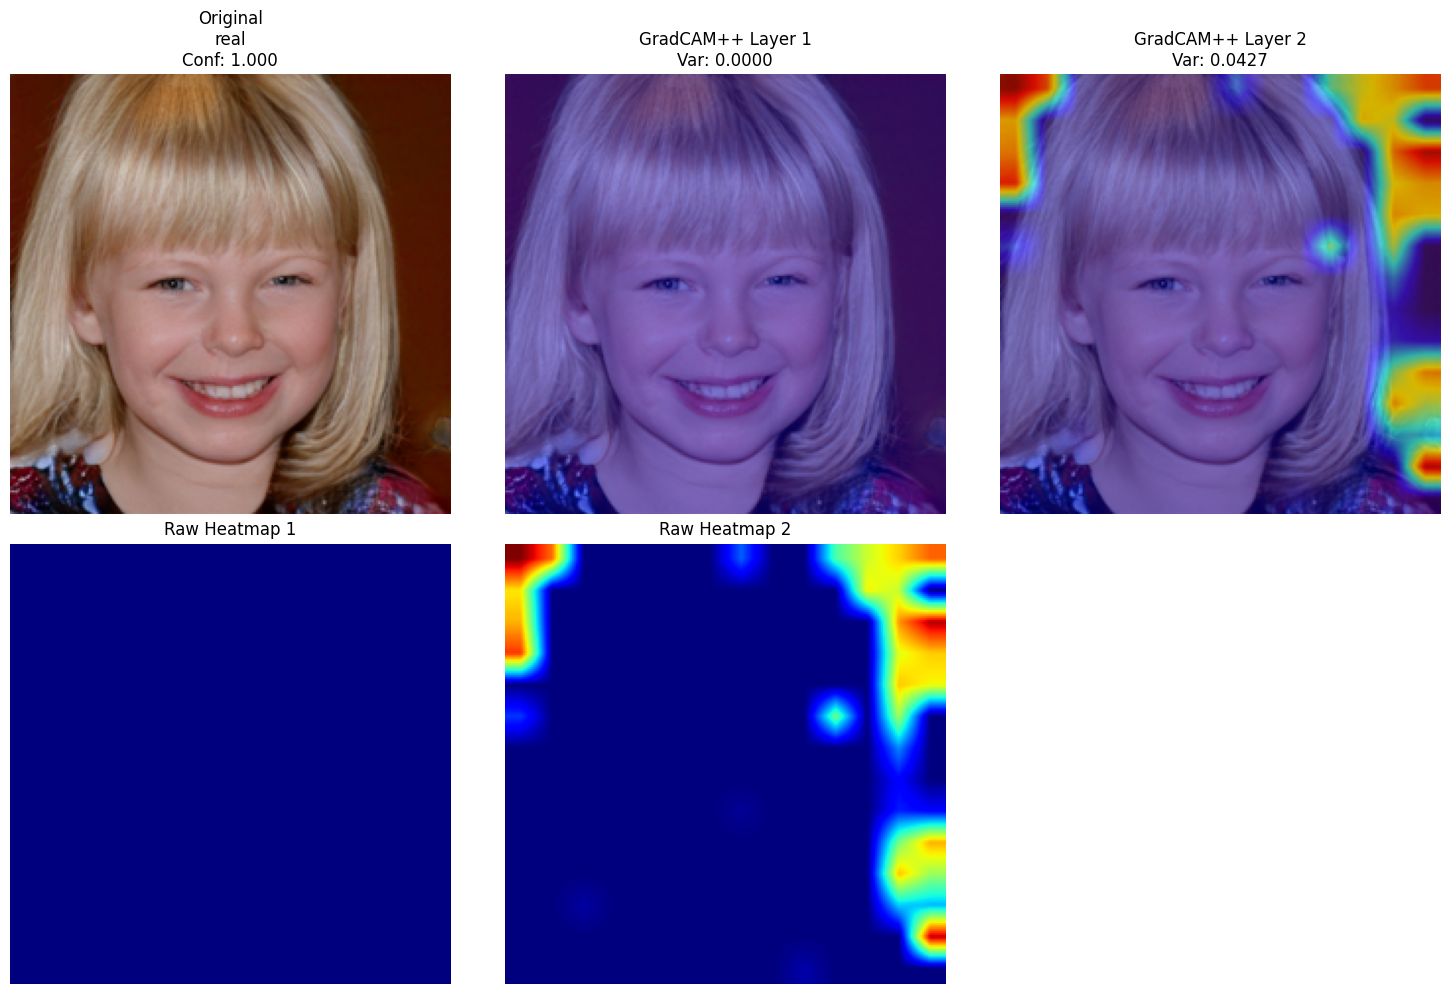

  - /content/temp_extract/001328.png


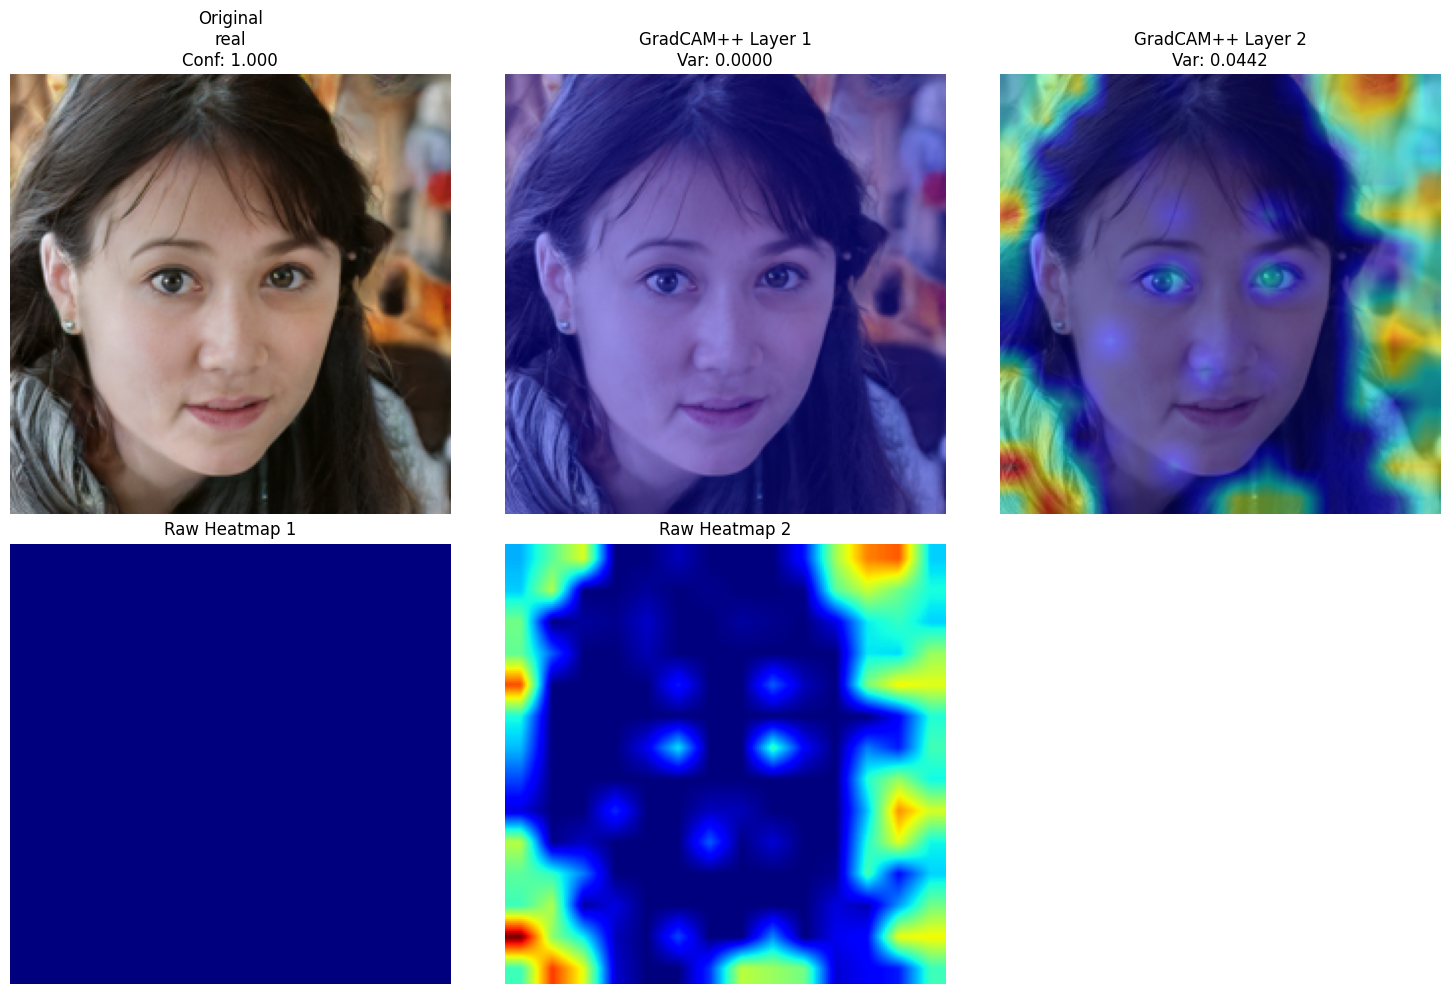

In [ ]:
# Quick fixes for your existing code:

# 1. Try different target layers
target_layers_options = [
    [loaded_model.vit.encoder.layer[-1].attention.output],  # Your current
    [loaded_model.vit.encoder.layer[-2].attention.output],  # Second to last
    [loaded_model.vit.encoder.layer[-1].layernorm_after],   # Layer norm
    [loaded_model.vit.layernorm],                           # Final layer norm
]

# 2. Enhanced reshape transform
def better_reshape_transform(tensor, height=14, width=14):
    # Ensure we have the right dimensions
    if len(tensor.shape) == 3 and tensor.size(1) > height * width:
        result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    else:
        result = tensor.reshape(tensor.size(0), height, width, -1)
    result = result.permute(0, 3, 1, 2)
    return result

# 3. Try GradCAM++ instead
from pytorch_grad_cam import GradCAMPlusPlus

# 4. Modified visualization function with multiple attempts
def improved_visualize_grad_cam(image_path, model, processor):
    try:
        pil_image = Image.open(image_path).convert("RGB")
        resized_pil_image = pil_image.resize((224, 224))
        numpy_image = np.array(resized_pil_image) / 255.0

        input_tensor = processor(images=pil_image, return_tensors="pt")['pixel_values']

        # Get prediction with confidence
        output = model(pixel_values=input_tensor)
        logits = output.logits
        probabilities = torch.softmax(logits, dim=-1)
        predicted_class_id = logits.argmax().item()
        confidence = probabilities[0, predicted_class_id].item()

        targets = [ClassifierOutputTarget(predicted_class_id)]

        plt.figure(figsize=(15, 10))

        # Original image
        plt.subplot(2, 3, 1)
        plt.imshow(resized_pil_image)
        plt.title(f"Original\n{model.config.id2label[predicted_class_id]}\nConf: {confidence:.3f}")
        plt.axis('off')

        # Try different target layers
        for i, target_layer in enumerate(target_layers_options[:2]):
            try:
                # Try GradCAM++
                cam = GradCAMPlusPlus(model=wrapped_model, target_layers=target_layer,
                                    reshape_transform=better_reshape_transform)

                grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
                grayscale_cam = grayscale_cam[0, :]

                visualization = show_cam_on_image(numpy_image, grayscale_cam, use_rgb=True)

                plt.subplot(2, 3, i + 2)
                plt.imshow(visualization)
                plt.title(f"GradCAM++ Layer {i+1}\nVar: {np.var(grayscale_cam):.4f}")
                plt.axis('off')

                # Show raw heatmap
                plt.subplot(2, 3, i + 4)
                plt.imshow(grayscale_cam, cmap='jet')
                plt.title(f"Raw Heatmap {i+1}")
                plt.axis('off')

            except Exception as e:
                print(f"Error with layer {i}: {e}")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

num_to_visualize = 3
if len(fake_images) >= num_to_visualize:
    images_to_visualize = random.sample(fake_images, num_to_visualize)
    print(f"\nVisualizing Grad-CAM for {num_to_visualize} random fake images:")
    for path in images_to_visualize:
        print(f"  - {path}")
        improved_visualize_grad_cam(path, loaded_model, loaded_processor)
else:
    print(f"Not enough fake images to visualize {num_to_visualize}. Found only {len(fake_images)}.")